In [1]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as torch_functional

import torchvision.models as models

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [121]:
training_dir = "../dataset/train/"
val_dir = "../dataset/val/"
testing_dir = "./dataset/test/"
train_batch_size = 8
train_number_epochs = 25
IMAGE_SIZE = 224

In [141]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset: dset.folder.ImageFolder, transform=None):
        self.imageFolderDataset: dset.folder.ImageFolder = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        #return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32)) #dissimilarity index
        return img0, img1, img0_tuple[1], img1_tuple[1]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [142]:
folder_loader = dset.ImageFolder(root=training_dir)
train_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose(
                                            [transforms.RandomRotation(30), #data augumnetation
                                             transforms.CenterCrop(IMAGE_SIZE),#resize
                                             #transforms.RandomResizedCrop(IMAGE_SIZE),
                                             transforms.RandomHorizontalFlip(), #data augumnetation
                                             transforms.ToTensor()]
                                        )
                                       )

val_loader = dset.ImageFolder(root=val_dir)
val_dataset = SiameseNetworkDataset(imageFolderDataset=val_loader,
                                        transform=transforms.Compose(
                                            [transforms.RandomRotation(30), #data augumnetation
                                             transforms.CenterCrop(IMAGE_SIZE),#resize
                                             #transforms.RandomResizedCrop(IMAGE_SIZE),
                                             transforms.RandomHorizontalFlip(), #data augumnetation
                                             transforms.ToTensor()]
                                        )
                                       )

test_loader = dset.ImageFolder(root=testing_dir)
test_dataset = SiameseNetworkDataset(imageFolderDataset=test_loader,
                                        transform=transforms.Compose(
                                            [transforms.RandomRotation(30), #data augumnetation
                                             transforms.CenterCrop(IMAGE_SIZE),#resize
                                             #transforms.RandomResizedCrop(IMAGE_SIZE),
                                             transforms.RandomHorizontalFlip(), #data augumnetation
                                             transforms.ToTensor()]
                                        )
                                       )

In [143]:
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        batch_size=train_batch_size)

val_dataloader = DataLoader(val_dataset,
                        shuffle=False,
                        batch_size=train_batch_size)

test_dataloader = DataLoader(test_dataset,
                        shuffle=False,
                        batch_size=train_batch_size)

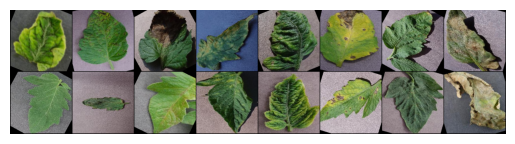

[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]


In [144]:
vis_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        batch_size=8)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))

for i, j in zip(example_batch[2], example_batch[3]):
    print([int(i == j)])
#torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

In [145]:
folder_dataset.class_to_idx

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [128]:
a_model = models.alexnet()
(a_model.classifier._modules)['6'] = nn.Linear(4096, 10)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

a_model.load_state_dict(torch.load("../alexnet.torch", weights_only=True))

<All keys matched successfully>

In [129]:
del (a_model.classifier._modules)['6']
del (a_model.classifier._modules)['5']

In [130]:
a_model.classifier._modules

OrderedDict([('0', Dropout(p=0.5, inplace=False)),
             ('1', Linear(in_features=9216, out_features=4096, bias=True)),
             ('2', ReLU(inplace=True)),
             ('3', Dropout(p=0.5, inplace=False)),
             ('4', Linear(in_features=4096, out_features=4096, bias=True))])

In [167]:
class SiameseNetwork(nn.Module):
    def __init__(self, backbone):
        super(SiameseNetwork, self).__init__()
        self.backbone = backbone
        out_features = list(self.backbone.modules())[-1].out_features

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(out_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Dropout(0.5),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img0, img1):
        with torch.no_grad():
            out0 = self.backbone(img0)
            out1 = self.backbone(img1)

        combined = out0 * out1

        output = self.fc(combined)
        return output

model = SiameseNetwork(a_model).to(device)

In [169]:
counter = []
loss_history = [] 
iteration_number= 0

In [170]:
epochs = 5

for epoch in range(epochs):
        print("[{} / {}]".format(epoch, epochs))
        model.train()

        losses = []
        correct = 0
        total = 0

        # Training Loop Start
        for (img1, img2, class1, class2) in train_dataloader:
            img1, img2 = map(lambda x: x.to(device), [img1, img2])

            prob = model(img1, img2)
            prob = prob.reshape(prob.size(1), -1)[0]

            y = torch.FloatTensor([classi==classj for classi, classj in zip(class1, class2)]).to(device)
            #print(prob, y)
            loss = criterion(prob, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            correct += torch.count_nonzero(y == (prob > 0.5)).item()
            total += len(y)

        writer.add_scalar('train_loss', sum(losses)/len(losses), epoch)
        writer.add_scalar('train_acc', correct / total, epoch)

        print("\tTraining: Loss={:.2f}\t Accuracy={:.2f}\t".format(sum(losses)/len(losses), correct / total))
        # Training Loop End

        # Evaluation Loop Start
        model.eval()

        losses = []
        correct = 0
        total = 0

        for (img1, img2, class1, class2) in val_dataloader:
            img1, img2 = map(lambda x: x.to(device), [img1, img2])

            prob = model(img1, img2)
            prob = prob.reshape(prob.size(1), -1)[0]
            y = torch.FloatTensor([classi==classj for classi, classj in zip(class1, class2)]).to(device)
            loss = criterion(prob, y)

            losses.append(loss.item())
            correct += torch.count_nonzero(y == (prob > 0.5)).item()
            total += len(y)

        val_loss = sum(losses)/max(1, len(losses))
        writer.add_scalar('val_loss', val_loss, epoch)
        writer.add_scalar('val_acc', correct / total, epoch)

        print("\tValidation: Loss={:.2f}\t Accuracy={:.2f}\t".format(val_loss, correct / total))

[0 / 5]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

In [109]:
idx_to_class = {v:k for k, v in folder_dataset.class_to_idx.items()}
idx_to_class

{0: 'Tomato___Bacterial_spot',
 1: 'Tomato___Early_blight',
 2: 'Tomato___Late_blight',
 3: 'Tomato___Leaf_Mold',
 4: 'Tomato___Septoria_leaf_spot',
 5: 'Tomato___Spider_mites Two-spotted_spider_mite',
 6: 'Tomato___Target_Spot',
 7: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 8: 'Tomato___Tomato_mosaic_virus',
 9: 'Tomato___healthy'}

In [119]:
losses = []
correct = 0
total = 0

[1 / 10]


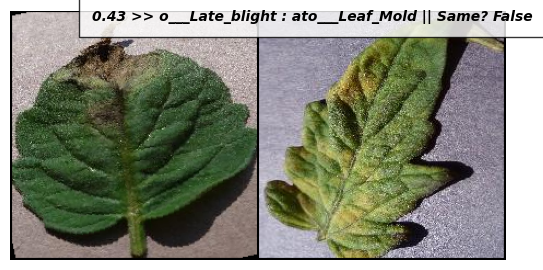

[2 / 10]


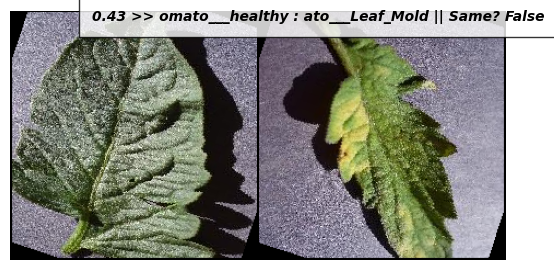

[3 / 10]


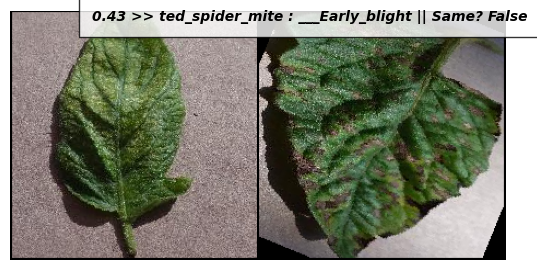

[4 / 10]


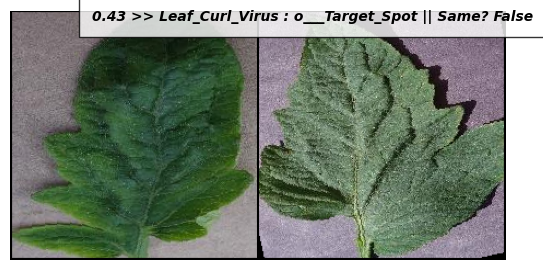

[5 / 10]


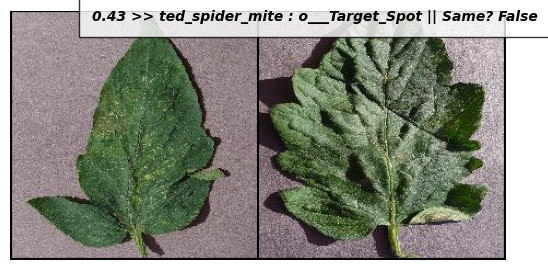

[6 / 10]


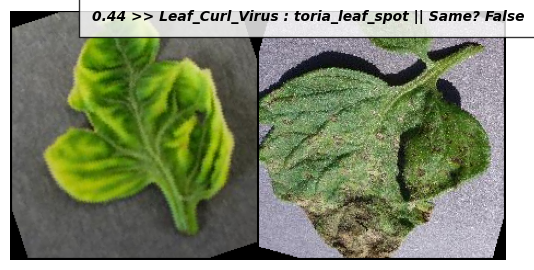

[7 / 10]


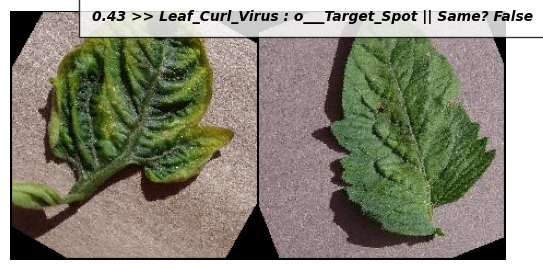

[8 / 10]


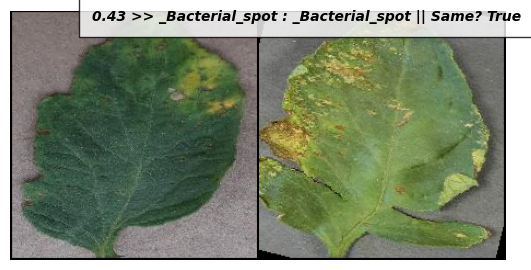

[9 / 10]


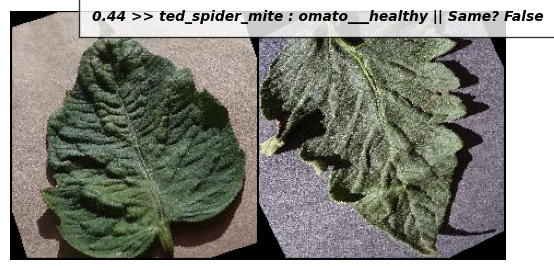

[10 / 10]


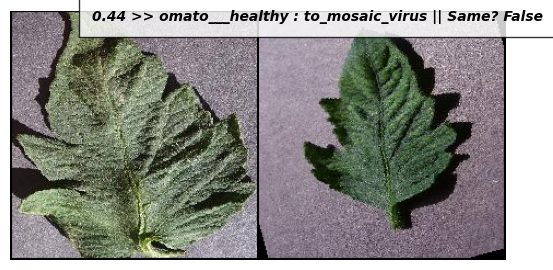

[11 / 10]
[12 / 10]
[13 / 10]
[14 / 10]
[15 / 10]
[16 / 10]
[17 / 10]
[18 / 10]
[19 / 10]
[20 / 10]
[21 / 10]
[22 / 10]
[23 / 10]
[24 / 10]
[25 / 10]
[26 / 10]
[27 / 10]
[28 / 10]
[29 / 10]
[30 / 10]
[31 / 10]
[32 / 10]
[33 / 10]
[34 / 10]
[35 / 10]
[36 / 10]
[37 / 10]
[38 / 10]
[39 / 10]
[40 / 10]
[41 / 10]
[42 / 10]
[43 / 10]
[44 / 10]
[45 / 10]
[46 / 10]
[47 / 10]
[48 / 10]
[49 / 10]
[50 / 10]
[51 / 10]
[52 / 10]
[53 / 10]
[54 / 10]
[55 / 10]
[56 / 10]
[57 / 10]
[58 / 10]
[59 / 10]
[60 / 10]
[61 / 10]
[62 / 10]
[63 / 10]
[64 / 10]
[65 / 10]
[66 / 10]
[67 / 10]
[68 / 10]
[69 / 10]
[70 / 10]
[71 / 10]
[72 / 10]
[73 / 10]
[74 / 10]
[75 / 10]
[76 / 10]
[77 / 10]
[78 / 10]
[79 / 10]
[80 / 10]
[81 / 10]
[82 / 10]
[83 / 10]
[84 / 10]
[85 / 10]
[86 / 10]
[87 / 10]
[88 / 10]
[89 / 10]
[90 / 10]
[91 / 10]
[92 / 10]
[93 / 10]
[94 / 10]
[95 / 10]
[96 / 10]
[97 / 10]
[98 / 10]
[99 / 10]
[100 / 10]
[101 / 10]
[102 / 10]
[103 / 10]
[104 / 10]
[105 / 10]
[106 / 10]
[107 / 10]
[108 / 10]
[109 / 10]



KeyboardInterrupt



In [120]:
val_dataloader = DataLoader(siamese_dataset,
                            shuffle=False,
                            batch_size=1
                           )
model.eval()
for i, (img0, img1, class0, class1) in enumerate(val_dataloader):
    print("[{} / 10]".format(i+1, len(val_dataloader)))

    img0, img1 = map(lambda x: x.to(device), [img0, img1])
    class0 = class0[0]
    class1 = class1[0]

    prob = model(img0, img1)[0]
    y = torch.FloatTensor([class0==class1]).to(device)
    loss = criterion(prob, y)

    losses.append(loss.item())
    correct += torch.count_nonzero(y == (prob > 0.5)).item()
    total += len(y)

    #fig = plt.figure("class1={}\tclass2={}", figsize=(4, 2))
    #plt.suptitle("cls1={}  conf={:.2f}  cls2={}".format(class1, prob[0][0].item(), class2))

    # show first image
    if i < 10:
        concatenated = torch.cat((img0, img1),0).cpu()
        imshow(torchvision.utils.make_grid(concatenated), f"{float(prob):0.2f} >> {idx_to_class[int(class0)][-15:]} : {idx_to_class[int(class1)][-15:]} || Same? {bool(int(y))}")

    # show the plot
    #plt.savefig(os.path.join(args.out_path, '{}.png').format(i))

print("Validation: Loss={:.2f}\t Accuracy={:.2f}\t".format(sum(losses)/len(losses), correct / total))